In [1]:
# %pip install kaggle transfomers --quiet

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, LabelEncoder
from transformers import pipeline
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
# Read the log tracker data
df = pd.read_csv('../data/raw/CS-GY-6923 Log Tracker  - Daily Questions.csv')

# Check the column names to see if they align with the wellness dataset
print(df.columns)

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True)
    .str.replace(r"\s+", "_", regex=True)
)

print(df.columns)

# Display the first few rows to check the changes
print(df.head())

Index(['Date', 'Duration of Sleep (hours)', 'Quality of Sleep  (1-10)',
       'Daily Weigh-in', 'BMI Category',
       'Nutrition Intake (calories, breakdown of nutrients, etc.)',
       'Level of Physical Activity (minutes per day)', 'Heart Rate (bpm)',
       'Systolic and Diastolic Blood Pressure',
       'Level of Stress (scale: 1–10)', 'Level of Workload (scale: 1–10)',
       'Environmental Aspects (such as weather and air quality)',
       'Additional health indicators (e.g., water levels, steps)',
       'Mood Output', 'Notes'],
      dtype='object')
Index(['date', 'duration_of_sleep_hours', 'quality_of_sleep_110',
       'daily_weighin', 'bmi_category',
       'nutrition_intake_calories_breakdown_of_nutrients_etc',
       'level_of_physical_activity_minutes_per_day', 'heart_rate_bpm',
       'systolic_and_diastolic_blood_pressure', 'level_of_stress_scale_110',
       'level_of_workload_scale_110',
       'environmental_aspects_such_as_weather_and_air_quality',
       'additio

In [4]:
# Encode the 'Emotion Classification' column
if df['mood_output'].dtype == 'object':
    le = LabelEncoder()
    df['mood_output_encoded'] = le.fit_transform(df['mood_output'])

# Compute correlations with the numeric columns
numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()['mood_output_encoded']

# Print the sorted correlation values
print(corr_matrix.sort_values(ascending=False))


mood_output_encoded                           1.000000
duration_of_sleep_hours                       0.690789
quality_of_sleep_110                          0.653193
heart_rate_bpm                                0.187871
level_of_physical_activity_minutes_per_day    0.169333
daily_weighin                                -0.139006
level_of_workload_scale_110                  -0.696417
level_of_stress_scale_110                    -0.722488
Name: mood_output_encoded, dtype: float64


In [5]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Check if 'mood_output_encoded' exists (which should be the numeric version of mood)
if 'mood_output_encoded' in numeric_df.columns:
    corr_matrix = numeric_df.corr()['mood_output_encoded']
    print(corr_matrix)
else:
    print("Make sure you have an encoded 'mood_output_encoded' column.")


duration_of_sleep_hours                       0.690789
quality_of_sleep_110                          0.653193
daily_weighin                                -0.139006
level_of_physical_activity_minutes_per_day    0.169333
heart_rate_bpm                                0.187871
level_of_stress_scale_110                    -0.722488
level_of_workload_scale_110                  -0.696417
mood_output_encoded                           1.000000
Name: mood_output_encoded, dtype: float64


## 1. Demographic Health Grouping

In [6]:
# Read Initial Questions sheet for additonal data on the user
initial_df = pd.read_csv('../data/raw/CS-GY-6923 Log Tracker  - Initial Questions.csv')

# Extract the last row of the DataFrame
last_updated_entry = initial_df.iloc[-1]

# De-structure relevant information from column into variables
gender = last_updated_entry['Gender']
age = last_updated_entry['Age']
height = last_updated_entry['Height']
quality_social_interactions = last_updated_entry['Quality or frequency of social interactions']


In [7]:
# Function to calculate BMI
def calculate_bmi(weight_lbs, height_in=height):
    # Helper function to calculate BMI
    height_m = height_in * 2.54 / 100
    weight_kg = weight_lbs / 2.20462
    return weight_kg / (height_m ** 2)

def get_recommended_calories(age, gender, activity_minutes):
    # Helper function to get recommended daily calorie intake
    if gender.lower() == 'male':
        if age < 30:
            base = 2500
        elif age < 50:
            base = 2400
        else:
            base = 2200
    else:  # female
        if age < 30:
            base = 2000
        elif age < 50:
            base = 1900
        else:
            base = 1800

    # Adjust based on activity level
    if activity_minutes >= 60:
        adjustment = 200  # active
    elif activity_minutes >= 30:
        adjustment = 100  # moderately active
    else:
        adjustment = 0  # sedentary

    return base + adjustment

# Function to classify demographic grouping
def classify_demographic_grouping(row, height_in, age, gender):
    # Extract age, gender, weight, and height from the daily log tracker data
    activity_minutes = float(row.get('level_of_physical_activity_minutes_per_day', 20))  # Default activity time in minutes

    # Check if essential columns are missing values
    if age is None or gender is None:
        return 'MISSING_DATA'

    # Extract nutrition intake from the 'nutrition_intake_calories_breakdown_of_nutrients_etc' column
    nutrition_intake = 0
    try:
        nutrition_text = row['nutrition_intake_calories_breakdown_of_nutrients_etc']
        # print(nutrition_text)
        match = re.search(r"(\d+)\s*[cC]alories", nutrition_text)
        if match:
            calories = int(match.group(1))
            # print("Calories:", calories)
            nutrition_intake = calories
        else:
            raise ValueError("Calories cannnot be read.")
        # nutrition_intake = float(row['nutrition_intake_calories_breakdown_of_nutrients_etc'])
    except (ValueError, TypeError,AttributeError, IndexError):
        return 'MISSING DATA'

    # Extract height and weight from the log tracker daily data
    weight_lbs = row.get('daily_weighin', None)

    # Calculate BMI if height and weight are available, else use category-based BMI value
    try:
        if height_in and weight_lbs:
            bmi = calculate_bmi(float(weight_lbs), float(height_in))
        else:
            category = str(row.get('bmi_category', 'normal')).lower()
            bmi_values = {'underweight': 17, 'normal': 22, 'overweight': 27, 'obese': 32}
            bmi = bmi_values.get(category, 22)
    except (ValueError, TypeError):
        bmi = 22

    # Determine BMI category
    if bmi < 18.5:
        bmi_category = 'underweight'
    elif 25 <= bmi < 30:
        bmi_category = 'overweight'
    elif bmi >= 30:
        bmi_category = 'obese'
    else:
        bmi_category = 'normal'

    # Calculate the recommended calorie intake based on activity level
    factor = {'underweight': 1.25, 'normal': 1.0, 'overweight': 0.7, 'obese': 0.7}[bmi_category]
    recommended = get_recommended_calories(age, gender, activity_minutes)
    target = recommended * factor

    if recommended is None:
        return 'MISSING_DATA'

    if abs(nutrition_intake - target) <= 200:
        return 'HEALTHY_CONSUMPTION'
    elif abs(nutrition_intake - target) <= 400:
        return 'NEUTRAL_CONSUMPTION'
    else:
        return 'UNHEALTHY_CONSUMPTION'

# Apply classification to the dataset
df['demographic_health_grouping'] = df.apply(lambda row: classify_demographic_grouping(
        row, height, age, gender),
    axis=1)

# Display the updated columns and the first few rows of the DataFrame
print("Updated DataFrame:")
print(df.head())

print(df['demographic_health_grouping'].value_counts())


Updated DataFrame:
         date  duration_of_sleep_hours  quality_of_sleep_110  daily_weighin  \
0  03/14/2025                        4                     5          126.5   
1  03/15/2025                        5                     5          126.0   
2  03/16/2025                        6                     6          125.6   
3  03/17/2025                        6                     6          126.2   
4  03/18/2025                        7                     7          126.8   

  bmi_category nutrition_intake_calories_breakdown_of_nutrients_etc  \
0       Normal                           1750 Calories (Balanced)     
1       Normal                           1700 Calories (Balanced)     
2       Normal                    1800 Calories (High in Protein)     
3       Normal            1900 Calories (High in Carbs, Balanced)     
4       Normal            1760 Calories (Low in Protein, Healthy)     

   level_of_physical_activity_minutes_per_day  heart_rate_bpm  \
0             

## 2. Lifestyle Grouping

In [8]:
def classify_lifestyle_grouping(row, age_group='adult'):
    # Use the correct columns from the DataFrame
    sleep_hours = row['duration_of_sleep_hours']
    heart_rate = row['heart_rate_bpm']
    blood_pressure = row['systolic_and_diastolic_blood_pressure']

    # Define good sleep ranges by age group
    sleep_ranges = {
        'adult': (7, 9),
        'young_adult': (7, 9),
        'older_adult': (7, 8)
    }

    sleep_good_range = sleep_ranges.get(age_group, (7, 9))

    # Parse BP safely
    systolic, diastolic = 120, 80
    if isinstance(blood_pressure, str) and '/' in blood_pressure:
        try:
            systolic, diastolic = map(int, blood_pressure.split('/'))
        except ValueError:
            pass  # fallback defaults

    # Evaluate individual metrics
    good_sleep = sleep_good_range[0] <= sleep_hours <= sleep_good_range[1]
    good_heart = 60 <= heart_rate <= 100
    good_bp = systolic < 130 and diastolic < 80

    # Create descriptive labels
    sleep_health = 'GOOD_SLEEP' if good_sleep else 'POOR_SLEEP'
    heart_health = 'GOOD_HEART_RATE' if good_heart else 'POOR_HEART_RATE'
    bp_health = 'GOOD_BLOOD_PRESSURE' if good_bp else 'POOR_BLOOD_PRESSURE'

    # Overall lifestyle grouping
    if good_sleep and good_heart and good_bp:
        lifestyle = 'GOOD'
    elif good_sleep or good_heart or good_bp:
        lifestyle = 'NEUTRAL'
    else:
        lifestyle = 'POOR'

    return pd.Series([sleep_health, heart_health, bp_health, lifestyle])

# Apply to dataframe and assign new columns
df[['sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping']] = df.apply(
    lambda row: classify_lifestyle_grouping(row),
    axis=1
)

# Display the updated DataFrame
df[['date', 'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping']].head()


,date,sleep_health,heart_health,bp_health,lifestyle_grouping
0,03/14/2025,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL
1,03/15/2025,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL
2,03/16/2025,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL
3,03/17/2025,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL
4,03/18/2025,GOOD_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,GOOD


## 3. Activity Level Grouping

In [9]:
# Extract steps data from the 'Additional health indicators'
def extract_steps(text):
    indicator = text
    try:
        steps_text = indicator.split(',', 1)[-1].strip()  # Get last part like "10,000 steps"
        steps_number = int(steps_text.split(" ")[0].replace(',', ''))  # Remove comma and convert to int
        return steps_number
    except (IndexError, ValueError, AttributeError):
        return 0

df['extracted_steps'] = df['additional_health_indicators_eg_water_levels_steps'].apply(extract_steps)

# Function to classify Activity Level
def classify_activity_level(minutes, steps):
    if pd.isna(steps) or pd.isna(minutes):
        return 'UNKNOWN'
    steps = float(steps)
    minutes = float(minutes)

    if steps < 5000 and minutes < 30:
        return 'SEDENTARY'
    elif (5000 <= steps < 7500) or (30 <= minutes < 45):
        return 'LIGHTLY_ACTIVE'
    elif (7500 <= steps < 10000) or (45 <= minutes < 60):
        return 'SOMEWHAT_ACTIVE'
    elif (10000 <= steps < 12500) or (60 <= minutes < 75):
        return 'ACTIVE'
    else:
        return 'HIGHLY_ACTIVE'

# Apply Activity Level Classification
df['activity_level_grouping'] = df.apply(
    lambda row: classify_activity_level(
        row['level_of_physical_activity_minutes_per_day'],
        row['extracted_steps']
    ),
    axis=1
)


df[df.columns].head()


,date,duration_of_sleep_hours,quality_of_sleep_110,daily_weighin,bmi_category,nutrition_intake_calories_breakdown_of_nutrients_etc,level_of_physical_activity_minutes_per_day,heart_rate_bpm,systolic_and_diastolic_blood_pressure,level_of_stress_scale_110,...,mood_output,notes,mood_output_encoded,demographic_health_grouping,sleep_health,heart_health,bp_health,lifestyle_grouping,extracted_steps,activity_level_grouping
0,03/14/2025,4,5,126.5,Normal,1750 Calories (Balanced),60,71,117/55,6,...,Negative,"Barely had any sleep, feeling terrible",0,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,1000,ACTIVE
1,03/15/2025,5,5,126.0,Normal,1700 Calories (Balanced),20,69,114/53,5,...,Neutral,Regular day,1,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,2105,SEDENTARY
2,03/16/2025,6,6,125.6,Normal,1800 Calories (High in Protein),75,68,111/51,3,...,Positive,"Went out for a long jog, I enjoyed it",2,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,8851,SOMEWHAT_ACTIVE
3,03/17/2025,6,6,126.2,Normal,"1900 Calories (High in Carbs, Balanced)",80,70,102/55,2,...,Positive,"Went out for a short jog and lifted weights, i...",2,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,2251,HIGHLY_ACTIVE
4,03/18/2025,7,7,126.8,Normal,"1760 Calories (Low in Protein, Healthy)",90,67,118/53,3,...,Positive,"Went out for a long jog, good weather, it was ...",2,UNHEALTHY_CONSUMPTION,GOOD_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,GOOD,11080,ACTIVE


In [10]:
df['activity_level_grouping'].value_counts()

activity_level_grouping
SEDENTARY          24
SOMEWHAT_ACTIVE     4
ACTIVE              2
HIGHLY_ACTIVE       2
LIGHTLY_ACTIVE      2
Name: count, dtype: int64

## 4. Stress Profile Grouping

In [11]:
# Function to classify Stress
def classify_stress(stress):
    if stress <= 4:
        return 'LOW_STRESS'
    elif 5 <= stress <= 7:
        return 'MEDIUM_STRESS'
    else:
        return 'HIGH_STRESS'

# Function to classify Workload
def classify_workload(workload):
    if workload <= 4:
        return 'LOW_WORKLOAD'
    elif 5 <= workload <= 7:
        return 'MEDIUM_WORKLOAD'
    else:
        return 'HIGH_WORKLOAD'

df['stress_profile_grouping'] = df['level_of_stress_scale_110'].apply(classify_stress)
df['workload_profile_grouping'] = df['level_of_workload_scale_110'].apply(classify_workload)

df[df.columns].head()


,date,duration_of_sleep_hours,quality_of_sleep_110,daily_weighin,bmi_category,nutrition_intake_calories_breakdown_of_nutrients_etc,level_of_physical_activity_minutes_per_day,heart_rate_bpm,systolic_and_diastolic_blood_pressure,level_of_stress_scale_110,...,mood_output_encoded,demographic_health_grouping,sleep_health,heart_health,bp_health,lifestyle_grouping,extracted_steps,activity_level_grouping,stress_profile_grouping,workload_profile_grouping
0,03/14/2025,4,5,126.5,Normal,1750 Calories (Balanced),60,71,117/55,6,...,0,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,1000,ACTIVE,MEDIUM_STRESS,MEDIUM_WORKLOAD
1,03/15/2025,5,5,126.0,Normal,1700 Calories (Balanced),20,69,114/53,5,...,1,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,2105,SEDENTARY,MEDIUM_STRESS,LOW_WORKLOAD
2,03/16/2025,6,6,125.6,Normal,1800 Calories (High in Protein),75,68,111/51,3,...,2,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,8851,SOMEWHAT_ACTIVE,LOW_STRESS,LOW_WORKLOAD
3,03/17/2025,6,6,126.2,Normal,"1900 Calories (High in Carbs, Balanced)",80,70,102/55,2,...,2,UNHEALTHY_CONSUMPTION,POOR_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,NEUTRAL,2251,HIGHLY_ACTIVE,LOW_STRESS,LOW_WORKLOAD
4,03/18/2025,7,7,126.8,Normal,"1760 Calories (Low in Protein, Healthy)",90,67,118/53,3,...,2,UNHEALTHY_CONSUMPTION,GOOD_SLEEP,GOOD_HEART_RATE,GOOD_BLOOD_PRESSURE,GOOD,11080,ACTIVE,LOW_STRESS,LOW_WORKLOAD


In [12]:
df['stress_profile_grouping'].value_counts()


stress_profile_grouping
MEDIUM_STRESS    18
LOW_STRESS       15
HIGH_STRESS       1
Name: count, dtype: int64

In [13]:
df['workload_profile_grouping'].value_counts()

workload_profile_grouping
MEDIUM_WORKLOAD    19
LOW_WORKLOAD       14
HIGH_WORKLOAD       1
Name: count, dtype: int64

## 5. Social Wellness Grouping

In [14]:
# Note:
# - The facebook/bart-large-mnli model used here is a pre-trained model without fine-tuning on our specific data.
# - It has ~406 million parameters and achieves:
#   • ~84.6% accuracy on the MNLI matched set
#   • ~83.4% accuracy on the MNLI mismatched set
# - Citation for the model: Lewis et al., 2019 ("BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension")
#   Paper: https://arxiv.org/abs/1910.13461
# - Model card: https://huggingface.co/facebook/bart-large-mnli

# Load the model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define your candidate labels
labels = ['HIGH_SOCIAL', 'MODERATE_SOCIAL', 'LOW_SOCIAL']

quality_or_frequency_social_interactions = last_updated_entry['Quality or frequency of social interactions']

# Classify social level function
def classify_social(text):
    text = str(text).lower()
    result = classifier(text, candidate_labels=labels)
    return result['labels'][0]  # take the top label

classification_result = classify_social(quality_or_frequency_social_interactions)

df["social_wellness_grouping"] = classification_result

df[['social_wellness_grouping']].head()


Device set to use cuda:0


,social_wellness_grouping
0,MODERATE_SOCIAL
1,MODERATE_SOCIAL
2,MODERATE_SOCIAL
3,MODERATE_SOCIAL
4,MODERATE_SOCIAL


## 6. Environmental Stress Grouping

In [15]:
def fetch_weather_data(city_name, api_key):
    """
    Fetch current weather description from WeatherAPI for a given city.
    """
    url = f'http://api.weatherapi.com/v1/current.json?key={api_key}&q={city_name}'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        if 'current' in data and 'condition' in data['current']:
            return data['current']['condition']['text']
        else:
            print("Warning: Weather data structure is incomplete.")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching weather data: {e}")
        return None


def classify_weather_situation(weather_description):
    """
    Classify weather condition into one of: SUNNY, RAINY, CLOUDY, WINDY, or UNKNOWN.
    """
    description = weather_description.lower()

    if 'sunny' in description:
        return 'SUNNY'
    elif 'rain' in description or 'shower' in description:
        return 'RAINY'
    elif 'overcast' in description or 'cloud' in description:
        return 'CLOUDY'
    elif 'wind' in description:
        return 'WINDY'
    else:
        return 'UNKNOWN'

# Define the API key and city name
city_name = 'Boston'

# Fetch the weather description
# weather_description = fetch_weather_data(city_name, api_key)

# if weather_description:
#     weather_situation = classify_weather_situation(weather_description)
#     print(f"City: {city_name}")
#     print(f"Weather Description: {weather_description}")
#     print(f"Classified Weather Situation: {weather_situation}")
# else:
#     print("Unable to fetch or classify weather data.")


# View the processed DataFrame

In [16]:
# Print all column names to confirm structure
print("Columns in the DataFrame:\n", df.columns.tolist())


Columns in the DataFrame:
 ['date', 'duration_of_sleep_hours', 'quality_of_sleep_110', 'daily_weighin', 'bmi_category', 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'level_of_physical_activity_minutes_per_day', 'heart_rate_bpm', 'systolic_and_diastolic_blood_pressure', 'level_of_stress_scale_110', 'level_of_workload_scale_110', 'environmental_aspects_such_as_weather_and_air_quality', 'additional_health_indicators_eg_water_levels_steps', 'mood_output', 'notes', 'mood_output_encoded', 'demographic_health_grouping', 'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping', 'extracted_steps', 'activity_level_grouping', 'stress_profile_grouping', 'workload_profile_grouping', 'social_wellness_grouping']


# Check Specific Columns

In [17]:
# --- Check Specific Columns ---
# This step ensures the required columns are present before further processing

# Check existence of specific columns
columns_to_check = ['social_wellness_grouping']
for col in columns_to_check:
    if col in df.columns:
        print(f"\nColumn '{col}' exists. Here are the first few values:")
        print(df[col].head())
    else:
        print(f"\nColumn '{col}' is missing from the DataFrame.")



Column 'social_wellness_grouping' exists. Here are the first few values:
0    MODERATE_SOCIAL
1    MODERATE_SOCIAL
2    MODERATE_SOCIAL
3    MODERATE_SOCIAL
4    MODERATE_SOCIAL
Name: social_wellness_grouping, dtype: object


In [18]:
df[['activity_level_grouping', 'stress_profile_grouping']].head()

,activity_level_grouping,stress_profile_grouping
0,ACTIVE,MEDIUM_STRESS
1,SEDENTARY,MEDIUM_STRESS
2,SOMEWHAT_ACTIVE,LOW_STRESS
3,HIGHLY_ACTIVE,LOW_STRESS
4,ACTIVE,LOW_STRESS


# Summary Statistics

In [19]:
df.describe()

,duration_of_sleep_hours,quality_of_sleep_110,daily_weighin,level_of_physical_activity_minutes_per_day,heart_rate_bpm,level_of_stress_scale_110,level_of_workload_scale_110,mood_output_encoded,extracted_steps
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,5.529412,5.941176,126.076471,26.617647,70.323529,4.764706,4.970588,1.294118,1976.323529
std,1.022039,0.951591,0.764381,27.980529,3.982694,1.415473,1.242805,0.759961,3186.554981
min,3.000000,4.000000,124.400000,5.000000,62.000000,2.000000,3.000000,0.000000,175.000000
25%,5.000000,5.000000,125.600000,5.000000,68.000000,4.000000,4.000000,1.000000,206.250000
50%,5.000000,6.000000,126.100000,10.000000,70.000000,5.000000,5.000000,1.000000,300.000000
75%,6.000000,7.000000,126.500000,45.000000,71.750000,6.000000,6.000000,2.000000,1953.750000
max,8.000000,8.000000,127.800000,90.000000,81.000000,8.000000,8.000000,2.000000,11080.000000


In [20]:
# Save the cleaned DataFrame to a CSV file
df.to_csv('../data/processed/processed_log_tracker.csv', index=False)

# Generic Analysis

**Analyzing Relationships Between Groupings**

In [21]:
print(df.columns)


Index(['date', 'duration_of_sleep_hours', 'quality_of_sleep_110',
       'daily_weighin', 'bmi_category',
       'nutrition_intake_calories_breakdown_of_nutrients_etc',
       'level_of_physical_activity_minutes_per_day', 'heart_rate_bpm',
       'systolic_and_diastolic_blood_pressure', 'level_of_stress_scale_110',
       'level_of_workload_scale_110',
       'environmental_aspects_such_as_weather_and_air_quality',
       'additional_health_indicators_eg_water_levels_steps', 'mood_output',
       'notes', 'mood_output_encoded', 'demographic_health_grouping',
       'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping',
       'extracted_steps', 'activity_level_grouping', 'stress_profile_grouping',
       'workload_profile_grouping', 'social_wellness_grouping'],
      dtype='object')


In [22]:
# Group by lifestyle grouping and check the average stress level
lifestyle_stress = df.groupby('lifestyle_grouping')['level_of_stress_scale_110'].mean()

# Display the result
print(lifestyle_stress)

lifestyle_grouping
GOOD       3.833333
NEUTRAL    4.964286
Name: level_of_stress_scale_110, dtype: float64


**Visualizing the Relationship:**

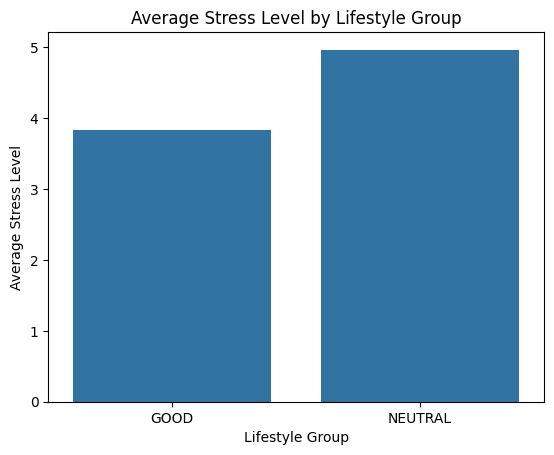

In [23]:
# Plotting the average stress level for each lifestyle group
sns.barplot(x=lifestyle_stress.index, y=lifestyle_stress.values)
plt.xlabel('Lifestyle Group')
plt.ylabel('Average Stress Level')
plt.title('Average Stress Level by Lifestyle Group')
plt.show()


**Clustering Analysis (Clustering Based on Groupings)**

With the groupings and other features, you can use clustering algorithms like KMeans, Agglomerative, or even DBSCAN to cluster individuals with similar characteristics.

KMeans Clustering:

In [24]:
# Select columns for clustering (e.g., physical activity, sleep, stress level, heart rate)
features = df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm']]
features = features.dropna()  # Drop rows with missing values

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans clustering (choose 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Show the cluster assignments
print(df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm', 'cluster']].head())


   level_of_physical_activity_minutes_per_day  duration_of_sleep_hours  \
0                                          60                        4   
1                                          20                        5   
2                                          75                        6   
3                                          80                        6   
4                                          90                        7   

   level_of_stress_scale_110  heart_rate_bpm  cluster  
0                          6              71        1  
1                          5              69        1  
2                          3              68        2  
3                          2              70        2  
4                          3              67        2  


**Predictive Modeling (Classification or Regression)**

You can build predictive models to predict specific outcomes, such as predicting the mood output based on the features, or predicting stress levels based on other health factors.

Example - Mood Output Prediction (Classification):

Let's say you want to predict the mood output using features like stress level, sleep duration, and physical activity. You could apply a classification model (e.g., Random Forest, Logistic Regression).

In [25]:
# Prepare the data (assuming 'mood_output' is the target variable)
X = df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm']]
y = df['mood_output']

# Drop rows with missing values in target or features
X = X.dropna()
y = y.loc[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         2
     Neutral       1.00      1.00      1.00         3
    Positive       1.00      1.00      1.00         2

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



**Visualization of Groupings and Health Indicators**

Visualizing the different groups and their health indicators can be insightful, especially to spot patterns and trends.

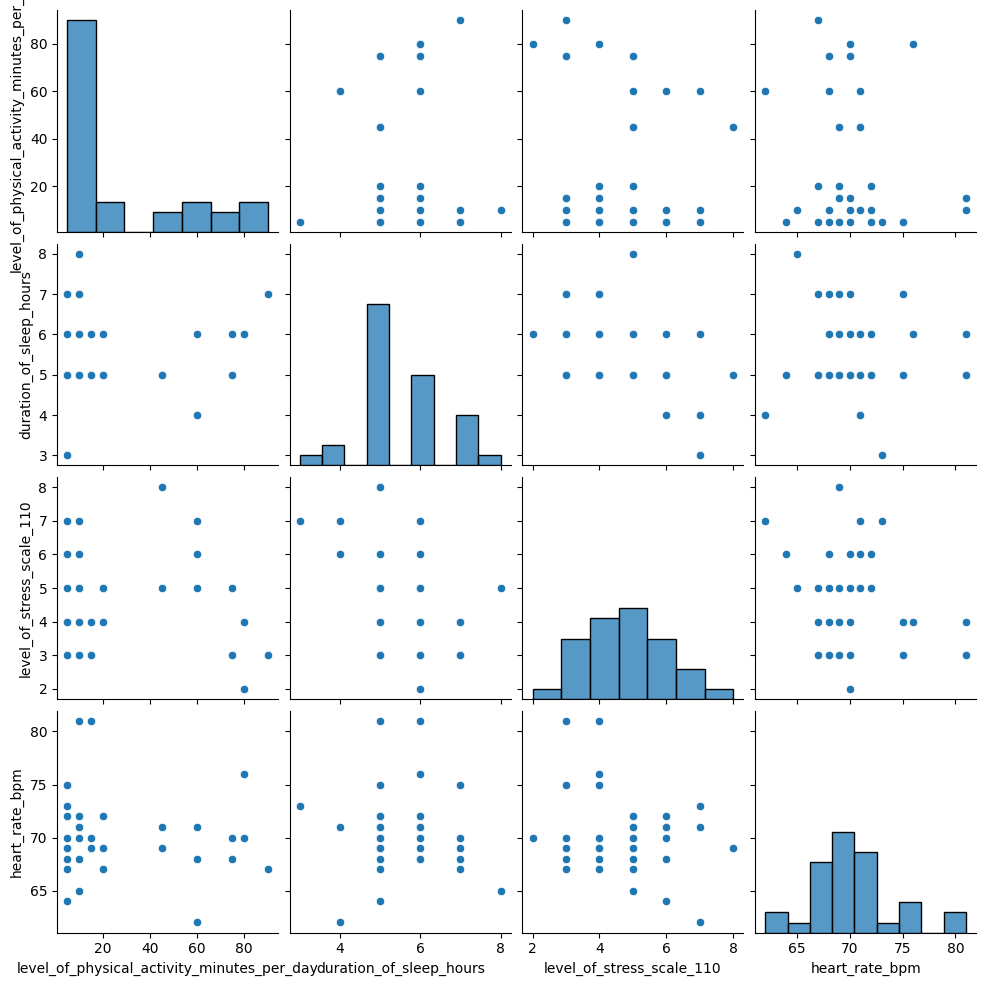

In [26]:
# Pairplot to check the relationships between selected features (e.g., stress, sleep, activity)
sns.pairplot(df[['level_of_physical_activity_minutes_per_day', 'duration_of_sleep_hours', 'level_of_stress_scale_110', 'heart_rate_bpm']])
plt.show()

**Convert Mood to Numeric and Calculate Mean**

In [27]:
# Map mood values to numeric
mood_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['mood_output_numeric'] = df['mood_output'].map(mood_mapping)

# Group by lifestyle and calculate the average mood (numeric)
lifestyle_mood_avg = df.groupby('lifestyle_grouping')['mood_output_numeric'].mean()

# Display the result
print(lifestyle_mood_avg)


lifestyle_grouping
GOOD       1.000000
NEUTRAL    0.142857
Name: mood_output_numeric, dtype: float64


**Summary Stats for Categorical Columns**

In [28]:
# Get value counts of mood output by lifestyle group
lifestyle_mood_counts = df.groupby('lifestyle_grouping')['mood_output'].value_counts()

print(lifestyle_mood_counts)


lifestyle_grouping  mood_output
GOOD                Positive        6
NEUTRAL             Neutral        12
                    Positive       10
                    Negative        6
Name: count, dtype: int64


In [29]:
# Load the CSV file
df = pd.read_csv('processed_log_tracker.csv')

# Display the first few rows
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'processed_log_tracker.csv'

Column Names:
 ['date', 'duration_of_sleep_hours', 'quality_of_sleep_110', 'daily_weighin', 'bmi_category', 'nutrition_intake_calories_breakdown_of_nutrients_etc', 'level_of_physical_activity_minutes_per_day', 'heart_rate_bpm', 'systolic_and_diastolic_blood_pressure', 'level_of_stress_scale_110', 'level_of_workload_scale_110', 'environmental_aspects_such_as_weather_and_air_quality', 'additional_health_indicators_eg_water_levels_steps', 'mood_output', 'notes', 'mood_output_encoded', 'demographic_health_grouping', 'sleep_health', 'heart_health', 'bp_health', 'lifestyle_grouping', 'extracted_steps', 'activity_level_grouping', 'stress_profile_grouping', 'workload_profile_grouping', 'social_wellness_grouping', 'Mood_Numeric', 'Cluster']

Value Counts for Categorical Columns:

date:
date
03/14/2025    1
03/15/2025    1
03/16/2025    1
03/17/2025    1
03/18/2025    1
03/19/2025    1
03/20/2025    1
03/21/2025    1
03/22/2025    1
03/23/2025    1
03/24/2025    1
03/25/2025    1
03/26/2025    1

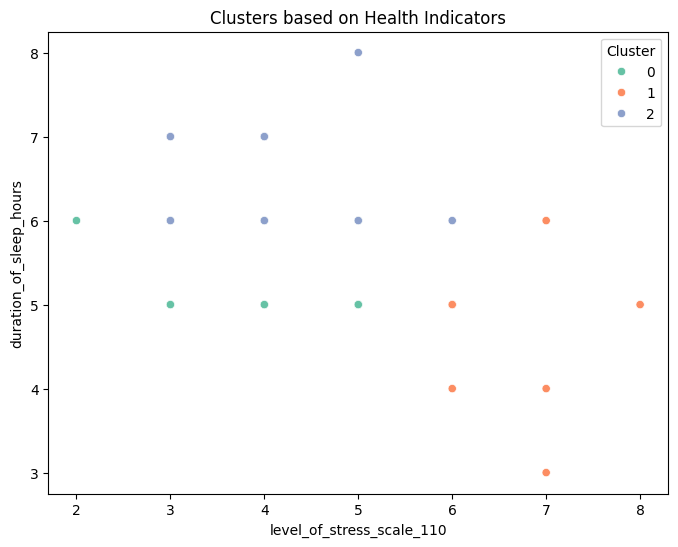


Classification Report for Mood Prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         2

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [ ]:
# Preview column names
print("Column Names:\n", df.columns.tolist())

# Clean column names
df.columns = df.columns.str.strip()

# Value Counts for Categorical Columns
cat_cols = df.select_dtypes(include=['object']).columns
print("\nValue Counts for Categorical Columns:")
for col in cat_cols:
    print(f"\n{col}:\n{df[col].value_counts()}")

# Convert Mood to Numeric and Summary Stats for Categorical Columns
if 'mood_output' in df.columns:
    df['Mood_Numeric'] = LabelEncoder().fit_transform(df['mood_output'])

print("\nSummary Stats for Categorical Columns:")
print(df.describe(include='object'))

# Clustering Analysis
features_for_clustering = ['level_of_stress_scale_110', 'duration_of_sleep_hours', 'quality_of_sleep_110']
features_for_clustering = [col for col in features_for_clustering if col in df.columns]

if features_for_clustering:
    X_scaled = StandardScaler().fit_transform(df[features_for_clustering].dropna())

    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    print("\nCluster Counts:")
    print(df['Cluster'].value_counts())

    # Visualize clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[features_for_clustering[0]], y=df[features_for_clustering[1]], hue=df['Cluster'], palette='Set2')
    plt.title('Clusters based on Health Indicators')
    plt.show()

# Predictive Modeling: Mood Output Prediction
model_features = ['level_of_stress_scale_110', 'duration_of_sleep_hours', 'quality_of_sleep_110']
model_features = [col for col in model_features if col in df.columns]
if 'Mood_Numeric' in df.columns and all(col in df.columns for col in model_features):
    X = df[model_features]
    y = df['Mood_Numeric']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("\nClassification Report for Mood Prediction:")
    print(classification_report(y_test, y_pred))
